<a href="https://colab.research.google.com/github/OscarRojasG/Experimentos-GPTValidator/blob/main/Framework_Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework para experimentos GPTValidator

El objetivo de este framework consiste en proporcionar un conjunto de funciones previamente implementadas para facilitar la evaluación y comparación de prompts para el proyecto EvaluAI.

## Instrucciones de uso

En primer lugar, es necesario ejecutar **TODAS** las celdas de código de la sección Implementación.

### 1. Cargar dataset

1. Subir archivo .xlsx con todos los datasets combinados. Debe contener al menos 5 columnas con los siguientes datos:
    * **Contexto** (context): Conocimiento previo que necesita el modelo para evaluar la respuesta del estudiante.
    * **Pregunta** (question)
    * **Respuesta** (answer): Respuesta del estudiante
    * **Evaluación manual** (real_eval): Puntaje de referencia dado por uno o más evaluadores humanos.
    * **Dataset de origen** (dataset): Dataset del cual provienen los datos para una fila en particular.

2. Especificar el nombre de las columnas en un diccionario con la siguiente estructura (ejemplo):

    ```
    column_data = {
            "context": "Contexto",
            "question": "Pregunta",
            "answer": "Respuesta",
            "real_eval": "EvalManual",
            "dataset": "Dataset"
    }
    ```

3. Cargar dataset con la función `load_dataset(path, sheet_name, column_data)`

    - **path** - Ruta del archivo xlsx a utilizar.
    - **sheet_name** - Nombre de la hoja donde se encuentran los datos.
    - **column_data** - Diccionario explicado en el punto anterior.

### 2. Definir miniprompts a evaluar

1. Subir carpeta con la colección de miniprompts. Los miniprompts deben estar definidos en archivos txt y agrupados en carpetas por categoría (ejemplos, analysis, feedback, etc.). **Se pueden crear nuevas carpetas sin restricciones**.

2. Seleccionar los miniprompts a utilizar para la generación de los prompts. Estos deben ser definidos en un diccionario donde la clave corresponde al nombre de la carpeta y el valor es el nombre del archivo txt con el miniprompt correspondiente. Se puede utilizar el comodín * como valor para probar con todos los miniprompts de esa carpeta.

    ```
    prompt_data = {
        "examples": "examples_XX.txt",
        "context": "knowledge_XX.txt",
        "question": "...",
        "answer": "...",
        "instructions": {
            "analysis": "*",
            "feedback": "...",
            "score": "...",
        }
    }
    ```

3. Cargar prompts con la función ``generate_prompts(prompt_data, prompt_folder)``

    - **prompt_data** - Diccionario explicado en el punto anterior.
    - **prompt_folder** - Ruta de la carpeta donde se encuentra la colección de miniprompts. (Ej: Experiments/Miniprompts)

#### Notas adicionales

En caso de tener problemas al subir la carpeta a colab, subirla como zip y ejecutar el comando

```
!unzip nombre_carpeta.zip
```

Los criterios deben ser definidos en las primeras líneas del miniprompt score con el símbolo $.

```
$correctness
$completeness
$clarity
(score) Assign a score between 0 and 10 to different criteria based on the student's answer and the generated feedback. Criteria are: correctness, completeness, clarity.
```

Las instrucciones de salida de algunos miniprompts como feedback y analysis, se pueden definir usando el símbolo # en la primera línea del archivo.

```
#very detailed feedback considering previous analysis (in spanish, within 150 words)
(feedback)
Provide Feedback to the student considering the analysis. **Do not be strict at all**.
It is enough that the student answer correctly and more or less completely the question. **Do not ask for additional information**.
Start by stating whether the answer is good/excelent or poor/insatisfactory.
If the answer is good/excelent, affirm the student's understanding and potentially add a brief note on why their response was particularly effective or comprehensive.
If the answer is poor/insatisfactory, clearly identify the inaccuracies or errors. Provide specific suggestions on how to improve, ensuring the feedback is constructive.
Within 150 words. In Spanish.
```

### 3. Realizar experimento

Evaluar los prompts con la función ``experiment(dataset, prompts, repetitions, eval_function, eval_params=None, train_set_size=60, test_set_size=100, seed=42)``

- **dataset** - Objeto de tipo DataFrame cargado en el punto 1.
- **prompts** - Colección de prompts cargados en el punto 2.
- **repetitions** - Número de repeticiones que se desea realizar la evaluación de cada prompt. Cada evaluación implica un nuevo conjunto de entrenamiento/prueba.
- **eval_function** - Método para convertir los puntajes GPT a escala 0-3. Puede ser "cuts" o "map".
- **eval_params** - Lista de parámetros usados para la conversión de puntajes. Son distintos dependiendo del valor de *eval_function*.
- **train_set_size** - Tamaño total $n$ del conjunto de entrenamiento. El conjunto de entrenamiento se encuentra compuesto por $n/4$ muestras de cada puntaje (balanceado).
- **test_set_size** - Tamaño total del conjunto de prueba (no balanceado).
- **seed** - Semilla utilizada para la creación de los conjuntos de prueba y entrenamiento.

Para ``eval_function = "cuts"`` los parámetros siguen la estructura $[w_1, w_2, ..., w_m, a, b, c]$

Para ``eval_function = "map"`` los parámetros siguen la estructura $[w_1, w_2, ..., w_m, a, b]$

En ambos casos, los primeros $m$ parámetros corresponden a las ponderaciones de cada criterio (en el mismo orden en que fueron definidos dentro del miniprompt score). La suma de las ponderaciones debe ser 1. En caso de no haber criterios, existe una única ponderación igual a 1.

Para la evaluación por cortes, los parámetros $a, b, c$ corresponden a los puntajes de corte ordenados de menor a mayor. Por ejemplo, para un prompt con 2 criterios, una lista de parámetros válidos podría ser $[0.7, 0.3, 3, 5, 7]$

Para la evaluación por mapeo, los parámetros $a, b$ representan los puntajes en escala 0-10 que corresponden a los puntajes 1 y 2 en escala 0-3. Por ejemplo:

$\text{map}(0) = 0$

$\text{map}(a) = 1$

$\text{map}(b) = 2$

$\text{map}(10) = 3$

# Implementación

In [ ]:
!pip install openai==0.28 &> /dev/null
!pip install openai-multi-client &> /dev/null
!git clone https://github.com/rilianx/GPTEvaluator &> /dev/null

## Cargar dataset

In [ ]:
import pandas as pd
from IPython.display import display

# Muestra información relevante del dataset
def show_dataset_info(dataset):
    display(dataset.head())
    print()
    print(dataset.value_counts("real_eval"), end="\n\n")
    print(dataset.value_counts("dataset"))
    pass

# Carga un dataset a partir de un archivo xlsx y valida sus columnas
def load_dataset(path, sheet_name, column_data):
    df = pd.read_excel(path, sheet_name=sheet_name)

    mandatory_cols = ["context", "question", "answer", "real_eval", "dataset"]
    for key in mandatory_cols:
        if key not in column_data.keys():
            raise Exception(f"Error: Debe especificar la columna para la variable {key}")

        value = column_data[key]
        if value not in df.columns:
            raise Exception(f"Error: La columna {value} no existe")

        df = df.rename(columns={value: key})

    df = df[mandatory_cols]
    show_dataset_info(df)
    return df

## Generación prompts

In [ ]:
import pprint
import copy
import json
import os
import re

class Prompt():
    def __init__(self, structure, instructions, base_folder):
        self.structure = structure
        self.instructions = instructions
        self.base_folder = base_folder
        self.raw_text_structure = None
        self.text_structure = None
        self.criteria = None
        self.output_instructions = None
        self.prompt = None

        self.read_files()
        self.extract_metadata()
        self.build_prompt()

    # Retorna la estructura base del prompt (diccionario)
    def base_structure(self):
        structure = copy.deepcopy(self.structure)
        structure['instructions'] = {}
        for i in self.instructions:
            structure['instructions'][i] = structure[i]
            structure.pop(i, None)
        return structure

    # Crea un diccionario con el contenido de cada archivo en la estructura
    def read_files(self):
        self.raw_text_structure = copy.deepcopy(self.structure)

        for key, value in self.raw_text_structure.items():
            if key == "instructions": continue

            path = f"{self.base_folder}/{key}/{value}"
            try:
                self.raw_text_structure[key] = open(path, 'r', encoding='utf-8').read()
                self.raw_text_structure[key] += "\n\n"
            except:
                raise Exception(f"Error: El archivo {path} no existe")

    # Extrae metadatos de los archivos como los criterios e instrucciones de salida
    def extract_metadata(self):
        self.text_structure = copy.deepcopy(self.raw_text_structure)

        if 'score' in self.text_structure:
            lines = self.text_structure['score'].split('\n')
            self.criteria = [line[1:] for line in lines if line.startswith('$')]
            text = [line for line in lines if not line.startswith('$')]
            self.text_structure['score'] = '\n'.join(text)

        self.output_instructions = {}
        output_mp = ["analysis", "feedback"]
        for key in output_mp:
            if key not in self.text_structure: continue
            value = self.text_structure[key]

            if value.startswith('#'):
                m = re.search(r'#(.*?)\n', value).group(1)
                self.output_instructions[key] = m
                self.text_structure[key] = '\n'.join(value.split('\n')[1:])

    # Construye el prompt en formato string
    def build_prompt(self):
        self.prompt = ""
        for key, value in self.text_structure.items():
            self.prompt += value

        output = "I expect a dict in python as answer: {{"
        for key, value in self.output_instructions.items():
            output += f'"{key}": \'{value}\', '

        if len(self.criteria) > 0:
            for c in self.criteria:
                output += f'"{c}": {c}_score, '
            output = output[:-2]
        else:
            output += '"score": score'

        output += "}}\n\nPython dict:"
        self.prompt += output


# Procesa y elimina los diccionarios anidados de prompt_data
def normalize_prompt_dict(prompt_data):
    instructions = []
    if "instructions" in prompt_data:
        for (key, value) in prompt_data["instructions"].items():
            prompt_data[key] = value
            instructions.append(key)

    prompt_data["instructions"] = "Instructions:\n"
    return prompt_data, instructions

# Retorna la lista de archivos para reemplazar el comodín *
def expand_prompt_data(prompt_data, prompt_folder):
    wildcard_field = None
    for key, value in prompt_data.items():
        if value == "*":
            wildcard_field = key
            break

    if not wildcard_field: return None, None

    wildcard_files = []
    path = f"{prompt_folder}/{wildcard_field}"
    for file in sorted(os.listdir(path)):
        if os.path.isfile(os.path.join(path, file)):
            wildcard_files.append(file)

    return wildcard_field, wildcard_files

# Genera una lista con los prompts a evaluar
def generate_prompts(prompt_data, prompt_folder):
    template, instructions = normalize_prompt_dict(prompt_data)
    wildcard_field, wildcard_files = expand_prompt_data(template, prompt_folder)
    prompts = []

    if wildcard_field == None:
        prompt = Prompt(template, instructions, prompt_folder)
        prompts.append(prompt)
        print(prompt.prompt)
        return prompts

    for file in wildcard_files:
        structure = copy.deepcopy(template)
        structure[wildcard_field] = file
        prompt = Prompt(structure, instructions, prompt_folder)
        prompts.append(prompt)

    # Visualizar
    template = copy.deepcopy(prompts[0])
    template.raw_text_structure[wildcard_field] = f"{{{wildcard_field}}}\n\n"
    template.extract_metadata()
    template.build_prompt()
    print(template.prompt)

    print(f"\n\nArchivos a utilizar ({len(wildcard_files)}):\n")
    print("\n".join(wildcard_files))

    return prompts

## Optimización parámetros

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np


### Optimización de cortes y ponderaciones ###
class CutsEvaluator():
    @staticmethod
    def f(x, theta):
        score = np.dot(x, theta[:-3])
        y_pred = np.where(score > theta[-1], 3, np.where(score > theta[-2], 2, np.where(score > theta[-3], 1, 0)))
        return y_pred

class CutsOptimizer():
    def __init__(self, criteria_scores, real_scores):
        bounds =  [(0, 1) for _ in range(len(criteria_scores[0]))] + [(1, 4), (4, 7), (7, 10)]
        result = differential_evolution(self.error, bounds, args=(criteria_scores, real_scores), seed=1, strategy='rand1exp', mutation=(0,1), recombination=1)
        self.params = result.x.tolist()

    def error(self, theta, x, y):
        y_pred = CutsEvaluator.f(x, theta)
        mse = np.mean((y - y_pred) ** 2)
        penalty = 1e6 * np.abs(np.sum(theta[:-3]) - 1)
        return mse + penalty


####### Optimización mapeo de puntajes ########
class MapEvaluator():
    @staticmethod
    def inverse_map(y_pred, theta):
        a, b = theta[-2], theta[-1]
        def single_inverse_map(y):
            if y <= a:
                return y / a
            elif a < y <= b:
                return 1 + (y - a) / (b - a)
            else:
                return 2 + (y - b) / (10 - b)

        return np.array([single_inverse_map(y) for y in y_pred])

    @staticmethod
    def f(x, theta):
        y_pred = np.dot(x, theta[:-2])
        return MapEvaluator.inverse_map(y_pred, theta)

class MapOptimizer():
    def __init__(self, criteria_scores, real_scores):
        bounds =  [(0, 1) for _ in range(len(criteria_scores[0]))] + [(1, 9), (1, 9)]
        result = differential_evolution(self.error, bounds, args=(criteria_scores, real_scores), seed=1, strategy='rand1exp', mutation=(0,1), recombination=1)
        self.params = result.x.tolist()

    def error(self, theta, x, y):
        y_pred = MapEvaluator.f(x, theta)
        mse = np.sum((y - y_pred) ** 2)
        penalty = 1e6 * np.abs(np.sum(theta[:-2]) - 1)
        a, b = theta[-2], theta[-1]
        if a > b: penalty += (a - b) * 1e5
        return mse + penalty

# Convierte una lista de diccionarios en una lista de tuplas
def get_x(gpt_dicts, criteria):
    if len(criteria) > 0:
        return [
            [gpt_dict[key] for key in criteria]
            for gpt_dict in gpt_dicts
        ]

    return [[gpt_dict['score']] for gpt_dict in gpt_dicts]

# Obtiene los parámetros óptimos para disminuir el error
def optimize_params(gpt_dicts, real_scores, criteria, eval_function):
    criteria_scores = get_x(gpt_dicts, criteria)
    if eval_function == "map":
        optimizer = MapOptimizer(criteria_scores, real_scores)
    if eval_function == "cuts":
        optimizer = CutsOptimizer(criteria_scores, real_scores)

    return optimizer.params

# Convierte los puntajes GPT a puntajes normalizados (0-3)
def convert_gpt_scores(gpt_dicts, real_scores, criteria, eval_function, eval_params):
    criteria_scores = get_x(gpt_dicts, criteria)
    if eval_function == "map":
        return MapEvaluator.f(criteria_scores, eval_params)
    if eval_function == "cuts":
        return CutsEvaluator.f(criteria_scores, eval_params)

In [ ]:
gpt_dicts = [
    {
        'score': 9
    },
    {
        'score': 8
    },
    {
        'score': 4
    }
]

real_scores = [3, 2, 1]
criteria = []

eval_params = optimize_params(gpt_dicts, real_scores, criteria, "map")
print(eval_params)
convert_gpt_scores(gpt_dicts, real_scores, criteria, "map", eval_params)

[1.0, 4.000037881048441, 7.4999888512711514]


array([2.60000178, 2.20000357, 0.99999053])

In [ ]:
gpt_dicts = [
    {
        'relevance': 8,
        'clarity': 9,
        'precision': 7
    },
    {
        'relevance': 8,
        'clarity': 5,
        'precision': 3
    },
    {
        'relevance': 4,
        'clarity': 1,
        'precision': 2
    }
]

real_scores = [3, 2, 1]
criteria = ['relevance', 'clarity', 'precision']

eval_params = optimize_params(gpt_dicts, real_scores, criteria, "map")
print(eval_params)
convert_gpt_scores(gpt_dicts, real_scores, criteria, "map", eval_params)

[0.007063405579985471, 0.9736191598576271, 0.01931743420011689, 1.0250005164759606, 4.822870728613848]


array([2.79801581, 2.03084424, 1.00408311])

## Experimentos

In [ ]:
import random
from GPTEvaluator.GPTEvaluator import chat_gpt_multiple
import matplotlib.pyplot as plt
from openai_multi_client import OpenAIMultiClient
import openai
from google.colab import userdata
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime, timedelta
import json
import numpy

openai.api_key = userdata.get('api_key')

class SetPair():
    def __init__(self, train_set, test_set):
        self.train_set = train_set
        self.test_set = test_set

# Divide el dataset en conjuntos de entrenamiento/prueba
def generate_sets(dataset, repetitions, train_set_size, test_set_size, seed, repeat_test_set):
    sets = []
    random.seed(seed)

    group_size = train_set_size // 4
    for i in range(repetitions):
        if repeat_test_set == False or i == 0:
            proportions = df['real_eval'].value_counts(normalize=True)
            samples_per_class = (proportions * test_set_size).round().astype(int)
            test_set = df.groupby('real_eval', group_keys=False)[df.columns.tolist()].apply(lambda x: x.sample(samples_per_class[x.name], random_state=random.randint(0,100000)))
            test_set = test_set.reset_index(drop=True)

        train_set = dataset[~dataset.index.isin(test_set.index)]
        train_set = train_set.groupby('real_eval', group_keys=False)[df.columns.tolist()].apply(lambda x: x.sample(group_size, random_state=random.randint(0,100000)))
        train_set = train_set.reset_index(drop=True)
        sets.append(SetPair(train_set, test_set))

    return sets

# Genera las respuestas con ChatGPT
def eval_gpt(df, prompt, model, temperature):
    api = OpenAIMultiClient(endpoint="chats", data_template={"model": model, "temperature": temperature, "n": 1, "timeout":10}, concurrency=50, wait_interval=1, max_retries=3, retry_max=10, retry_multiplier=1)

    texts = []
    for i, row in df.iterrows():
        text = prompt.format(Question=row['question'], Answer=row['answer'], Context=row['context'])
        texts.append(text)

    answers_gpt = chat_gpt_multiple(api, texts)
    return answers_gpt

# Extrae diccionario de salida de las respuestas GPT
def extract_dicts(answers_gpt):
    pattern = r'\{[^{}]+\}'

    gpt_dicts = []
    for answer_gpt in answers_gpt:
        try:
            answer = re.findall(pattern, answer_gpt[0])[0]
            gpt_dicts.append(eval(answer))
        except Exception as e:
            print(f"Error al extraer diccionario. Respuesta GPT: \n{answer_gpt[0]}\n\n")
            gpt_dicts.append(None)

    return gpt_dicts

# Elimina filas del dataset donde hubo errores en la salida GPT
def clean_set(dataset, gpt_dicts, criteria):
    for i in reversed(range(len(gpt_dicts))):
        if gpt_dicts[i] is None:
            gpt_dicts.pop(i)
            dataset.drop(index=i, inplace=True)
        elif all(key in gpt_dicts[i] for key in criteria) == False:
            print(gpt_dicts[i])
            gpt_dicts.pop(i)
            dataset.drop(index=i, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

# Obtiene los puntajes reales de un dataset
def get_real_scores(dataset):
    return dataset['real_eval'].tolist()

# Prepara el set de entrenamiento y obtiene los parámetros óptimos para disminuir el error
def train(train_set, prompt, criteria, eval_function, model, temperature):
    train_set = train_set.copy()
    answers_gpt = eval_gpt(train_set, prompt, model, temperature)
    gpt_dicts = extract_dicts(answers_gpt)
    clean_set(train_set, gpt_dicts, criteria)
    real_scores = get_real_scores(train_set)
    return optimize_params(gpt_dicts, real_scores, criteria, eval_function)

# Prepara el set de prueba y calcula las métricas del modelo preentrenado usando el conjunto de prueba
def test(test_set, prompt, criteria, eval_function, eval_params, model, temperature, normalize_mse):
    test_set2 = test_set.copy()
    answers_gpt = eval_gpt(test_set2, prompt, model, temperature)
    gpt_dicts = extract_dicts(answers_gpt)
    clean_set(test_set2, gpt_dicts, criteria)
    real_scores = get_real_scores(test_set2)
    pred_scores = convert_gpt_scores(gpt_dicts, real_scores, criteria, eval_function, eval_params)

    test_set2['gpt_eval'] = pred_scores
    df_dicts = pd.DataFrame(gpt_dicts)
    result_set = pd.concat([test_set2, df_dicts], axis=1)

    return calculate_mse(result_set, normalize_mse), result_set

# Retorna un dataset con el MSE por grupo
def calculate_mse(result_set, normalize):
    if normalize:
        mse_dict = result_set.groupby('dataset')[result_set.columns.tolist()].apply(lambda x: mean_squared_error(x['real_eval']/3, x['gpt_eval']/3)).to_dict()
        overall_mse = mean_squared_error(result_set['real_eval']/3, result_set['gpt_eval']/3)
    else:
        mse_dict = result_set.groupby('dataset')[result_set.columns.tolist()].apply(lambda x: mean_squared_error(x['real_eval'], x['gpt_eval'])).to_dict()
        overall_mse = mean_squared_error(result_set['real_eval'], result_set['gpt_eval'])

    mse_dict['All'] = overall_mse
    return mse_dict

# Muestra un gráfico con los puntajes obtenidos para cada pregunta ordenadas por puntaje real (0-3)
def show_distribution(full_df):
    full_df = full_df.pivot(index=['context','question', 'answer', 'real_eval', 'dataset', 'prompt'], columns='repetition', values=['gpt_eval', 'score'])
    full_df = full_df.reset_index().sort_values('real_eval')

    n = [full_df['real_eval'].value_counts()[x] for x in sorted(full_df['real_eval'].unique())]
    x_pos = [x + (y+1)/(n[x]+1) for x in range(4) for y in range(n[x])]

    def plot(col, title):
        dev = full_df[col].apply(lambda row: row.std(ddof=0), axis=1)
        mean = full_df[col].apply(lambda row: row.mean(), axis=1)

        plt.figure(figsize=(10, 6))

        if col == 'gpt_eval':
            plt.plot([0, 1], [0, 0], color='r', linewidth=1)
            plt.plot([1, 2], [1, 1], color='r', linewidth=1)
            plt.plot([2, 3], [2, 2], color='r', linewidth=1)
            plt.plot([3, 4], [3, 3], color='r', linewidth=1 )

        plt.errorbar(x_pos, mean, dev, linestyle='', capsize=4, color='cornflowerblue')
        plt.plot(x_pos, mean, marker='o', linestyle='', color='blue', markersize=4)
        plt.xticks([0, 1, 2, 3])
        plt.xlim(0, 4)

        plt.xlabel('Real Eval')
        plt.ylabel('GPT Eval')
        plt.title(title)
        plt.grid(True)
        plt.show()
        print()

    plot('gpt_eval', 'Distribución de puntajes GPT normalizados')
    plot('score', 'Distribución de puntajes GPT sin normalizar')

# Evalúa una lista de prompts obtienendo el MSE promedio en M repeticiones
def experiment(dataset, prompts, repetitions, eval_function, eval_params=None, train_set_size=40, test_set_size=60, seed=42, model="gpt-4o-mini", temperature=0.1, normalize_mse=False, repeat_test_set=True):
    sets = generate_sets(dataset, repetitions, train_set_size, test_set_size, seed, repeat_test_set)
    stats = []
    full_df = pd.DataFrame()

    for i, prompt_data in enumerate(prompts):
        prompt = prompt_data.prompt
        criteria = prompt_data.criteria
        stats.append([])

        for j in range(repetitions):
            train_set = sets[j].train_set
            test_set = sets[j].test_set

            iter_params = eval_params
            if not eval_params:
                print(f"Entrenando Prompt {i+1} con Train Set {j+1}")
                iter_params = train(train_set, prompt, criteria, eval_function, model, temperature)
                print()

            print(f"Evaluando Prompt {i+1} con Test Set {j+1}")
            metrics, result_set = test(test_set, prompt, criteria, eval_function, iter_params, model, temperature, normalize_mse)
            stats[i].append({
                "MSE": metrics,
                "params": iter_params
            })
            print()

            result_set['prompt'] = prompt
            result_set['repetition'] = j+1
            full_df = pd.concat([full_df, result_set], ignore_index=True)

    full_df.to_excel('final_set.xlsx', index=False)
    filename = save_stats(prompts, stats, eval_function, train_set_size, test_set_size, model, temperature)
    read_results(filename)

    if repeat_test_set == True and len(prompts) == 1:
        print()
        show_distribution(full_df)

    return stats

# Guarda resultados en un archivo JSON
def save_stats(prompts, stats, eval_function, train_set_size, test_set_size, model, temperature):
    data = {
        "model": model,
        "temperature": temperature,
        "train_set_size": train_set_size,
        "test_set_size": test_set_size,
        "repetitions": len(stats[0]),
        "results": []
    }

    for i in range(len(stats)):
        results = {
            "prompt": prompts[i].base_structure(),
            "stats": stats[i]
        }
        data["results"].append(results)

    dir = "Results"
    if not os.path.exists(dir):
        os.makedirs(dir)

    date = datetime.now() - timedelta(hours=4)
    formatted_date = date.strftime('%Y%m%d-%H%M')
    path = f'{dir}/{formatted_date}.json'
    with open(path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False)

    return path

# Lee y muestra resultados de un archivo JSON
def read_results(path):
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    rows = []
    for result in data["results"]:
        for i, stat in enumerate(result["stats"]):
            row = stat["MSE"]
            row["Prompt"] = json.dumps(result["prompt"])
            row["Repetition"] = i+1
            rows.append(row)

    df = pd.DataFrame(rows)
    col = df.pop('Prompt')
    df.insert(0, 'Prompt', col)
    col = df.pop('All')
    df.insert(1, 'All', col)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

    # Normalizar std
    '''
    def std(x): return np.std(x)
    df_norm = df[['Repetition', 'Prompt', 'All']].copy()

    mean_per_rep = df_norm[['Repetition', 'All']].groupby('Repetition', as_index=False).mean().reset_index(drop=True)
    mean_per_rep.rename(columns={'All': 'Mean'}, inplace=True)
    std_per_rep = df_norm[['Repetition', 'All']].groupby('Repetition', as_index=False).agg(std).reset_index(drop=True)
    std_per_rep.rename(columns={'All': 'Std'}, inplace=True)

    df_norm = df_norm.merge(mean_per_rep, on='Repetition', how='inner')
    df_norm = df_norm.merge(std_per_rep, on='Repetition', how='inner')

    df_norm['Norm'] = (df_norm['All'] - df_norm['Mean'])/df_norm['Std']
    df_norm = df_norm[['Prompt', 'Norm']].groupby('Prompt', as_index=False).agg(Mean=('Norm', 'mean'), Std=('Norm', std)).reset_index(drop=True)
    df_norm = df_norm.sort_values('Mean')

    print("\nTabla MSE normalizado")
    display(df_norm)
    '''

    # Sin normalizar std
    def std(x): return np.std(x)
    df_mean = df.drop(columns=["Repetition"]).groupby('Prompt', as_index=False).mean().reset_index(drop=True)
    df_mean = df_mean.sort_values('All')
    df_std = df.drop(columns=["Repetition"]).groupby('Prompt', as_index=False).agg(std).reset_index(drop=True)
    df_std = df_std.loc[df_mean.index]

    print("\nTabla Promedio MSE")
    display(df_mean)
    print("\nTabla Desviación estándar")
    display(df_std)

    pd.reset_option('^display.', silent=True)

# Espacio para experimentos

In [ ]:
column_data = {
    "context": "Contexto detallado",
    "question": "Pregunta",
    "answer": "Respuesta",
    "real_eval": "Promedio Redondeado",
    "dataset": "DataSet"
}

df = load_dataset("datasets_v2.xlsx", "AllDatasets (1dif)", column_data)

,context,question,answer,real_eval,dataset
0,BFS es preferible en problemas donde se busca ...,¿En qué tipo de problemas una búsqueda BFS pod...,El bfs es mucho mas util en ejecuciones cortas...,2,C3-Sample100
1,BFS es preferible en problemas donde se busca ...,¿En qué tipo de problemas una búsqueda BFS pod...,en una situación de resolución de un problema ...,2,C3-Sample100
2,BFS es preferible en problemas donde se busca ...,¿En qué tipo de problemas una búsqueda BFS pod...,en problemas donde pidan obtener el camino de ...,3,C3-Sample100
3,BFS es preferible en problemas donde se busca ...,¿En qué tipo de problemas una búsqueda BFS pod...,en problemas de grafos no ponderados ya que no...,3,C3-Sample100
4,La principal diferencia entre BFS y DFS radica...,¿Cuál es la principal diferencia entre búsqued...,La búsqueda por anchura tiene un procedimiento...,3,C3-Sample100



real_eval
3    127
2     75
0     52
1     36
Name: count, dtype: int64

dataset
C2-Nan                  92
C3-Sample100            91
C2-Sample100            90
C1-OscarBadAnswers20    17
Name: count, dtype: int64


In [ ]:
prompt_data = {
    "context": "context.txt",
    "examples_basic": "examples_0G4B_basic.txt",
    "question": "question.txt",
    "answer": "answer.txt",
    "instructions": {
        "analysis": "analysis_full.txt",
        "score": "score_single.txt"
    }
}

prompt_folder = "GPTEvaluator/Experiments/Miniprompts_v2"

prompts = generate_prompts(prompt_data, prompt_folder)

**Knowledge:** {Context}

### Examples
**Question**: ¿Cuando se recomienda utilizar arreglos en vez de listas enlazadas? Haga referencia a complejidades temporales en su explicación.
**Student's Answer**: Un arreglo es recomendable en determinadas situaciones, mientras que la lista enlazada en otras.
**Score**: 0

**Question**: ¿Cuál es la complejidad temporal del peor caso para la operación de búsqueda en una tabla hash y por qué? Describe las condiciones que debe tener la tabla para encontrarse en este peor caso.
**Student's Answer**: La complejidad del peor caso es ocurre cuando la tabla es inefectiva para realizar las operación de búsqueda.
**Score**: 0

**Question**: ¿Cómo se podría implementar un historial de navegación web usando dos pilas? El historial debe permitir ir hacia atrás y adelante con las páginas previamente visitadas. Describa un algoritmo.
**Student's Answer**: Usamos dos pilas para ir hacia adelante y hacia atrás en el historial.
**Score**: 0

**Question**: ¿Por q

Evaluando Prompt 1 con Test Set 1
16-5-4-0-39-10-23-7-21-44-41-6-29-32-9-28-3-24-33-13-42-17-40-2-46-1-43-48-27-18-37-38-49-36-12-26-15-31-34-35-11-30-45-19-20-14-8-57-54-22-47-25-59-58-52-55-53-51-56-50-
Evaluando Prompt 1 con Test Set 2
5-23-14-38-4-10-13-0-9-39-21-8-33-43-36-6-41-20-1-42-18-27-3-37-7-16-12-24-26-25-47-34-35-2-28-48-46-45-40-31-29-32-15-49-30-44-11-19-54-17-50-56-57-52-59-55-53-22-58-51-
Evaluando Prompt 1 con Test Set 3
4-9-0-43-29-8-7-15-21-3-46-23-39-5-6-47-17-33-16-24-49-40-37-38-13-35-45-10-26-32-25-2-48-36-11-44-20-30-28-34-12-31-1-14-42-18-50-54-41-22-19-57-56-27-58-59-53-52-51-55-
Evaluando Prompt 1 con Test Set 4
13-10-4-15-23-6-9-47-43-7-29-8-44-46-38-16-33-18-3-19-2-26-14-27-24-21-40-41-42-0-32-39-31-37-36-34-48-49-12-35-45-5-17-30-28-22-11-20-25-54-1-50-57-53-59-56-51-55-52-58-
Evaluando Prompt 1 con Test Set 5
29-3-8-24-4-44-25-0-14-47-7-46-15-43-20-18-21-27-9-19-17-38-5-37-42-6-45-39-40-48-10-2-33-26-31-23-16-13-30-12-41-36-49-32-28-11-1-22-57-54-50-59-

,Prompt,All,C1-OscarBadAnswers20,C2-Nan,C2-Sample100,C3-Sample100
0,"{""context"": ""context.txt"", ""examples_basic"": ""examples_0G4B_basic.txt"", ""question"": ""question.txt"", ""answer"": ""answer.txt"", ""instructions"": {""analysis"": ""analysis_full.txt"", ""score"": ""score_single.txt""}}",0.962213,0.60154,1.180189,0.881011,0.922989



Tabla Desviación estándar


,Prompt,All,C1-OscarBadAnswers20,C2-Nan,C2-Sample100,C3-Sample100
0,"{""context"": ""context.txt"", ""examples_basic"": ""examples_0G4B_basic.txt"", ""question"": ""question.txt"", ""answer"": ""answer.txt"", ""instructions"": {""analysis"": ""analysis_full.txt"", ""score"": ""score_single.txt""}}",0.031629,0.045452,0.072636,0.079467,0.068341


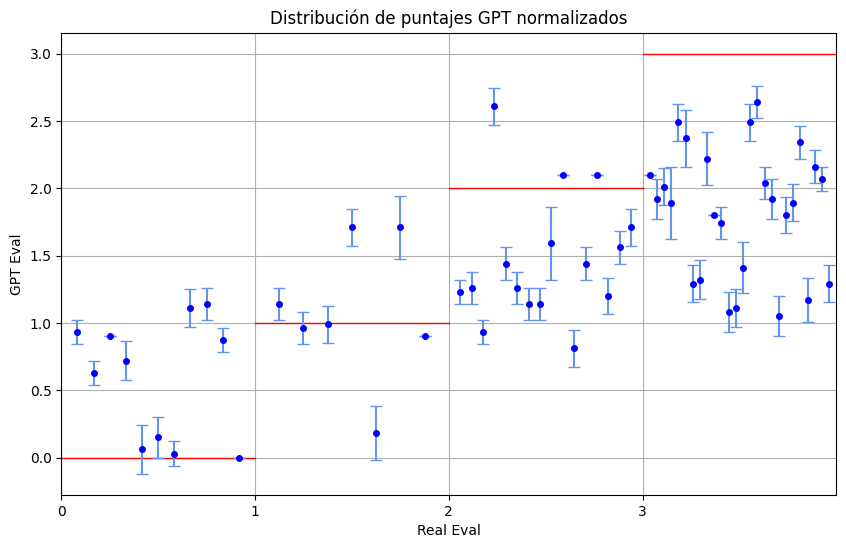

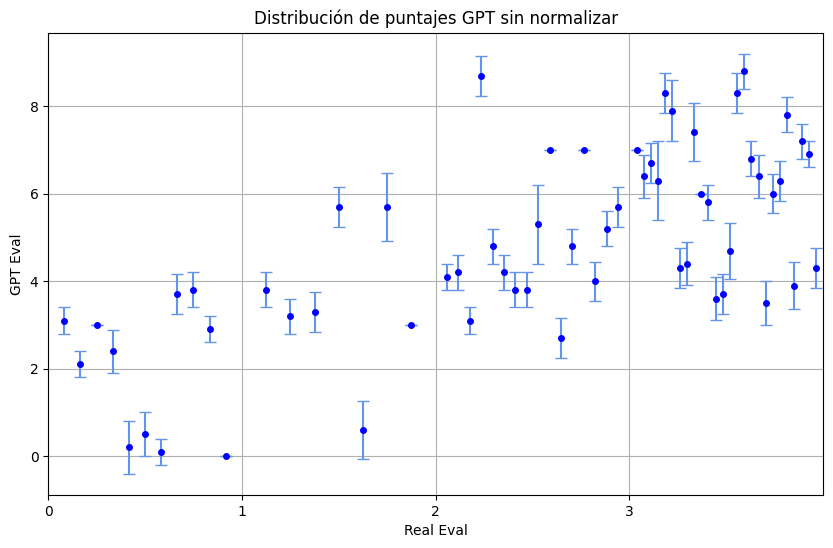

In [ ]:
x = experiment(df, prompts, repetitions=10, eval_function="map", eval_params=[1, 3.33, 6.66], train_set_size=40, test_set_size=60, seed=42, model="gpt-4o-mini", temperature=0.1, normalize_mse=False, repeat_test_set=True)

In [ ]:
!zip -r Results.zip Results/

  adding: Results/ (stored 0%)
  adding: Results/20240906-1645.json (deflated 62%)
  adding: Results/.ipynb_checkpoints/ (stored 0%)
  adding: Results/20240906-1525.json (deflated 65%)
  adding: Results/20240906-1538.json (deflated 65%)
  adding: Results/20240906-1529.json (deflated 65%)
  adding: Results/20240906-1519.json (deflated 65%)
  adding: Results/20240906-1534.json (deflated 65%)
  adding: Results/20240906-1641.json (deflated 62%)
  adding: Results/20240906-1522.json (deflated 65%)


# Extras

## Comparar MSE por temperatura

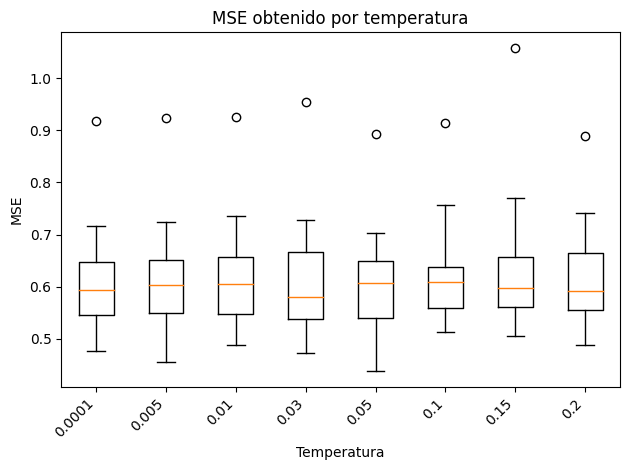

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Directorio donde se encuentran los archivos JSON
json_folder = 'Results'

# Lista para guardar los valores de MSE y las temperaturas
mse_values = []
temperatures = []

# Recorrer todos los archivos en la carpeta
for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        # Leer cada archivo JSON
        with open(os.path.join(json_folder, filename), 'r') as file:
            data = json.load(file)

            # Extraer valores de MSE["All"]
            mse_all_values = [stat["MSE"]["All"] for stat in data["results"][0]["stats"]]

            # Guardar los valores de MSE y las temperaturas
            mse_values.append(mse_all_values)
            temperatures.append(data["temperature"])

# Ordenar los valores de MSE y las temperaturas según la temperatura
temperatures, mse_values = zip(*sorted(zip(temperatures, mse_values)))

# Crear un boxplot con los datos ordenados por temperatura
plt.boxplot(mse_values, labels=[temp for temp in temperatures])
plt.title('MSE obtenido por temperatura')
plt.ylabel('MSE')
plt.xlabel('Temperatura')
plt.xticks(rotation=45, ha='right')  # Girar las etiquetas para mejor visibilidad
plt.tight_layout()  # Ajustar el layout para que no se corten las etiquetas
plt.show()